In [ ]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2


from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

ibmqfactory.load_account:WARNING:2020-08-21 22:24:01,457: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [13]:
inter_dist = 1.6

In [14]:
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')

We also setup the molecular orbitals to be considered and can reduce the problem size when we map to the qubit Hamiltonian so the amount of time required for the simulations are reasonable for a laptop computer.

In [15]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

In [16]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

In [17]:
backend = BasicAer.get_backend('statevector_simulator')

In [18]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

In [19]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + nuclear_repulsion_energy 
    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift

In [20]:
counts = []
values = []
params = []
deviation = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

In [21]:
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
for dist in distances:
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp(map_type='parity', inter_dist=dist)
    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp) + shift

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals, num_particles, "parity", qubit_reduction)

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    var_form = UCCSD(num_orbitals=num_spin_orbitals,
                     num_particles=num_particles,
                     initial_state=init_state,
                     qubit_mapping="parity")

    # Choose where to run/simulate our circuit
    quantum_instance = Aer.get_backend('statevector_simulator')

    # Choose the classical optimizer
    optimizer = SPSA()

    # Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)

    # Now compare the results of different compositions of your VQE algorithm!
    
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']) + shift
    print("Interatomic Distance:", np.round(1.4, 2), "VQE Result:", vqe_result, "Exact Energy:", ref)
    exact_energies.append(ref)
    vqe_energies.append(vqe_result)

HF energy: -10.20347336006194
# of electrons: 4
# of spin orbitals: 12
Reference value: -0.9792675459817607
Interatomic Distance: 1.4 VQE Result: -6.992843047770055 Exact Energy: -7.039732521635206
HF energy: -9.945427105942247
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0492360352400547
Interatomic Distance: 1.4 VQE Result: -7.313133674389818 Exact Energy: -7.313345828761003
HF energy: -9.753847203061563
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.10724092685153
Interatomic Distance: 1.4 VQE Result: -7.406386991471805 Exact Energy: -7.500922090905934
HF energy: -9.600184702182098
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.146159486057083
Interatomic Distance: 1.4 VQE Result: -7.5192830155582655 Exact Energy: -7.630978249333209
HF energy: -9.469677376536117
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.1666529075459429
Interatomic Distance: 1.4 VQE Result: -7.720521962661071 Exact Energy: -7.720812412134784
HF energy: -

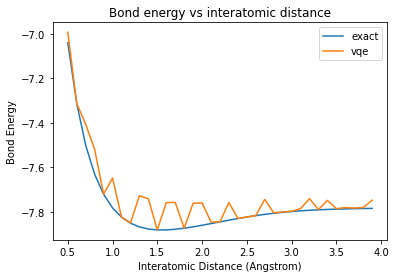

In [22]:
plt.plot(np.arange(0.5, 4.0, 0.1), exact_energies, label="exact")
plt.plot(np.arange(0.5, 4.0, 0.1), vqe_energies, label="vqe")
plt.xlabel('Interatomic Distance (Angstrom)')
plt.ylabel('Bond Energy')
plt.legend()
plt.title('Bond energy vs interatomic distance')
plt.show()

Testing COBYLA optimizer
HF energy: -8.790987097121477
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0547453451691517
Error: 0.003046283150111684
Testing L_BFGS_B optimizer
HF energy: -8.790987097121473
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0547453451691566
Error: 0.00312712719103736
Testing SLSQP optimizer
HF energy: -8.790987097121475
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0547453451691502
Error: 0.0030477465534906045
Testing SPSA optimizer
HF energy: -8.790987097121477
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0547453451691555
Error: 0.00019158416439601922


Text(0.5, 1.0, 'Energy Convergence of VQE: UCCSD Ansatz')

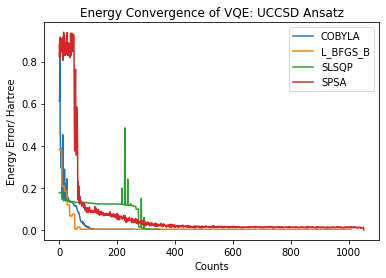

In [29]:
# Dictionary of optimizers:
opt_dict = {'SPSA' , 'SLSQP' , 'COBYLA' , 'L_BFGS_B'}

for opt in opt_dict:
    print('Testing', str(opt) , 'optimizer')
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp(map_type , 1.5)
    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp) + shift

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals,num_particles, qubit_mapping='parity') 

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    var_form = UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_mapping='parity')

    # Choose where to run/simulate our circuit
    quantum_instance = Aer.get_backend('statevector_simulator')

    # Choose the classical optimizer
    if opt == 'SPSA':
        optimizer = SPSA(max_trials = 500)
    elif opt == 'SLSQP':
        optimizer = SLSQP(maxiter = 1000)
    elif opt == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxfun = 1000 ,  maxiter = 1000)
    elif opt == 'COBYLA':
        optimizer = COBYLA(maxiter = 1000)
    
    counts =[]
    values =[]
    params =[]
    deviation =[]

    # Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer , callback = store_intermediate_result)
    vqe_results = vqe.run(quantum_instance)
    
    #Printing error in final value:
    ground_state_energy = vqe_results['eigenvalue'] + shift
    energy_error_ground = np.abs(np.real(ref) - ground_state_energy)
    print('Error:', str(energy_error_ground))
    # Calculating energy error
    vqe_energies = np.real(values) + shift
    energy_error = np.abs(np.real(ref) - vqe_energies)
    plt.plot(counts , energy_error , label=str(opt))
plt.legend()
plt.xlabel('Counts')
plt.ylabel('Energy Error/ Hartree')
plt.title('Energy Convergence of VQE: UCCSD Ansatz')

In [24]:
# Dictionary of optimizers:
opt_dict = {'SPSA' , 'SLSQP' , 'COBYLA' , 'L_BFGS_B'}

for opt in opt_dict:
    print('Testing', str(opt) , 'optimizer')
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp('parity' , 1.5)
    # Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp) + shift

    # Specify your initial state
    init_state = HartreeFock(num_spin_orbitals,num_particles, qubit_mapping='parity') 

    # Select a state preparation ansatz
    # Equivalently, choose a parameterization for our trial wave function.
    var_form = EfficientSU2(qubitOp.num_qubits , entanglement='full')

    # Choose where to run/simulate our circuit
    quantum_instance = Aer.get_backend('statevector_simulator')

    # Choose the classical optimizer
    if opt == 'SPSA':
        optimizer = SPSA(max_trials = 1000)
    elif opt == 'SLSQP':
        optimizer = SLSQP(maxiter = 1000)
    elif opt == 'L_BFGS_B':
        optimizer = L_BFGS_B(maxfun = 1000 ,  maxiter = 1000)
    elif opt == 'COBYLA':
        optimizer = COBYLA(maxiter = 1000)
    
    counts =[]
    values =[]
    params =[]
    deviation =[]

    # Run your VQE instance
    vqe = VQE(operator=qubitOp, var_form=var_form, optimizer=optimizer , callback = store_intermediate_result, quantum_instance=quantum_instance)
    vqe_results = vqe.run(quantum_instance)

    #Printing error in final value:
    ground_state_energy = vqe_results['eigenvalue'] + shift
    energy_error_ground = np.abs(np.real(ref) - ground_state_energy)
    print('Error:', str(energy_error_ground))
    
    # Calculating energy error
    vqe_energies = np.real(values) + shift
    energy_error = np.abs(np.real(ref) - vqe_energies)
    plt.plot(counts , energy_error , label=str(opt))
plt.legend()
plt.xlabel('Counts')
plt.ylabel('Energy Error/ Hartree')
plt.title('Energy Convergence of VQE: RyRz Ansatz')

Testing SPSA optimizer
HF energy: -8.92171204337512
# of electrons: 4
# of spin orbitals: 12
Reference value: -1.0990640886979137


AttributeError: 'Figure' object has no attribute 'single_string'

In [ ]:
# Trying all combinations to get the most efficiency
maps_types = ['parity'] # For 'bravyi_kitaev', 'jordan_wigner' we need another noise model eg ibmq_16_melbourne or ibmq_qasm_simulator

init_states = ["HartreeFock(num_spin_orbitals, num_particles, map_type, qubit_reduction)",
              "Zero(qubitOp.num_qubits)"]

var_forms = ["UCCSD(num_orbitals=num_spin_orbitals, num_particles=num_particles, active_occupied=[0], active_unoccupied=[0, 1], initial_state=init_state, qubit_mapping=map_type, two_qubit_reduction=qubit_reduction)",
             "RY(qubitOp.num_qubits, depth=depth)",
             "RYRZ(qubitOp.num_qubits, depth=depth)",
             "SwapRZ(qubitOp.num_qubits, depth=depth)"]

backends = [
           "Aer.get_backend('qasm_simulator')"]

optimizers = ["COBYLA(maxiter=opt_max_eval)",
            "L_BFGS_B(maxiter=opt_max_eval)",
            "SLSQP(maxiter=opt_max_eval)",
            "SPSA()"]
depth = 1
opt_max_eval = 200
for map_type in maps_types:
    for i_state in init_states:
        for v_form in var_forms:
            for be in backends:
                for opt in optimizers:
                    print("map_type: ", map_type)
                    print("i_state: ", i_state)
                    print("v_form: ", v_form)
                    print("be: ", be)
                    print("opt: ", opt)

                    qubitOp, num_spin_orbitals, num_particles, qubit_reduction = compute_LiH_qubitOp(map_type, inter_dist)
                    # Classically solve for the exact solution and use that as your reference value
                    ref = exact_solver(qubitOp)

                    # Specify your initial state
                    init_state = eval(i_state)

                    # Select a state preparation ansatz
                    # Equivalently, choose a parameterization for our trial wave function.
                    var_form = eval(v_form)

                    # Choose where to run/simulate our circuit
                    quantum_instance = QuantumInstance(backend=eval(be),
                                                        noise_model=noise_model,
                                                        measurement_error_mitigation_cls=CompleteMeasFitter,
                                                        seed_simulator=167, seed_transpiler=167,)

                    # Choose the classical optimizer
                    optimizer = eval(opt)

                    # Run your VQE instance
                    counts = []
                    values = []
                    params = []
                    deviation = []
                    algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
                    results = algo.run(quantum_instance)
                    print('VQE Results: {:.12f}'.format(results.eigenvalue.real))
                    print('The total ground state energy is: {:.12f}'.format(results.eigenvalue.real))
                    print("Parameters: {}".format(results.optimal_point))

                    #plt.plot(counts, label="count")
                    plt.plot(values, label="Zero")
                    plt.xlabel('Eval count')
                    plt.ylabel('energy minimisation for various optimizers ')
                    plt.legend()
                    plt.show()

                    #print(counts)
                    #print(values)
                    #print(params)
                    #print(deviation)
                    # Now compare the results of different compositions of your VQE algorithm!

                    ## 8
                    print("---")